In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values
# symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
symbols = string.ascii_uppercase +  "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (60, 160, 1)

In [2]:
print(symbols)
print(num_symbols)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
36


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    #we have 6 letters
    for _ in range(6):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('data/giro'))
    X = np.zeros((n_samples, 60, 160, 1)) #1070*60*160
    y = np.zeros((6, n_samples, num_symbols)) #6*1070*10

    for i, pic in enumerate(os.listdir('data/giro')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('data/giro', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 7:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (60, 160, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:1300], y[:, :1300]
X_test, y_test = X[1300:], y[:, 1300:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")


1300 training samples
469 validation samples


In [5]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 160, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 80, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4], y_train[5]], batch_size=32, epochs=500,verbose=1, validation_split=0.2)

Epoch 1/500
33/33 [==============================] - 3s 27ms/step - loss: 21.6488 - dense_1_loss: 3.4773 - dense_3_loss: 3.6236 - dense_5_loss: 3.6344 - dense_7_loss: 3.6493 - dense_9_loss: 3.6441 - dense_11_loss: 3.6202 - dense_1_accuracy: 0.0519 - dense_3_accuracy: 0.0269 - dense_5_accuracy: 0.0260 - dense_7_accuracy: 0.0327 - dense_9_accuracy: 0.0269 - dense_11_accuracy: 0.0269 - val_loss: 21.5133 - val_dense_1_loss: 3.6212 - val_dense_3_loss: 3.5770 - val_dense_5_loss: 3.5787 - val_dense_7_loss: 3.5795 - val_dense_9_loss: 3.5784 - val_dense_11_loss: 3.5785 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0423 - val_dense_5_accuracy: 0.0423 - val_dense_7_accuracy: 0.0423 - val_dense_9_accuracy: 0.0308 - val_dense_11_accuracy: 0.0308
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 21.1081 - dense_1_loss: 3.2773 - dense_3_loss: 3.5622 - dense_5_loss: 3.5794 - dense_7_loss: 3.5713 - dense_9_loss: 3.5605 - dense_11_loss: 3.5575 - dense_1_accuracy: 0

Epoch 12/500
33/33 [==============================] - 0s 14ms/step - loss: 12.1217 - dense_1_loss: 0.6773 - dense_3_loss: 1.9170 - dense_5_loss: 2.4841 - dense_7_loss: 2.2245 - dense_9_loss: 2.3678 - dense_11_loss: 2.4510 - dense_1_accuracy: 0.7731 - dense_3_accuracy: 0.4231 - dense_5_accuracy: 0.2471 - dense_7_accuracy: 0.3221 - dense_9_accuracy: 0.2740 - dense_11_accuracy: 0.2404 - val_loss: 22.0175 - val_dense_1_loss: 6.5152 - val_dense_3_loss: 2.9297 - val_dense_5_loss: 3.1930 - val_dense_7_loss: 3.0475 - val_dense_9_loss: 3.1551 - val_dense_11_loss: 3.1770 - val_dense_1_accuracy: 0.0154 - val_dense_3_accuracy: 0.2115 - val_dense_5_accuracy: 0.1923 - val_dense_7_accuracy: 0.2000 - val_dense_9_accuracy: 0.1885 - val_dense_11_accuracy: 0.1500
Epoch 13/500
33/33 [==============================] - 0s 14ms/step - loss: 10.8799 - dense_1_loss: 0.5473 - dense_3_loss: 1.7660 - dense_5_loss: 2.1851 - dense_7_loss: 1.9661 - dense_9_loss: 2.1825 - dense_11_loss: 2.2330 - dense_1_accuracy: 0.8

Epoch 23/500
33/33 [==============================] - 0s 13ms/step - loss: 4.8709 - dense_1_loss: 0.2202 - dense_3_loss: 0.7352 - dense_5_loss: 1.0511 - dense_7_loss: 0.8577 - dense_9_loss: 1.0471 - dense_11_loss: 0.9597 - dense_1_accuracy: 0.9125 - dense_3_accuracy: 0.7356 - dense_5_accuracy: 0.6298 - dense_7_accuracy: 0.7067 - dense_9_accuracy: 0.6471 - dense_11_accuracy: 0.6644 - val_loss: 36.2254 - val_dense_1_loss: 23.1648 - val_dense_3_loss: 2.2990 - val_dense_5_loss: 2.5423 - val_dense_7_loss: 2.8393 - val_dense_9_loss: 2.8272 - val_dense_11_loss: 2.5529 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.4115 - val_dense_5_accuracy: 0.3692 - val_dense_7_accuracy: 0.2962 - val_dense_9_accuracy: 0.3154 - val_dense_11_accuracy: 0.3269
Epoch 24/500
33/33 [==============================] - 0s 13ms/step - loss: 4.6715 - dense_1_loss: 0.2243 - dense_3_loss: 0.5879 - dense_5_loss: 1.0665 - dense_7_loss: 0.8666 - dense_9_loss: 1.0215 - dense_11_loss: 0.9047 - dense_1_accuracy: 0.92

Epoch 34/500
33/33 [==============================] - 0s 13ms/step - loss: 3.2186 - dense_1_loss: 0.1137 - dense_3_loss: 0.4394 - dense_5_loss: 0.7855 - dense_7_loss: 0.5815 - dense_9_loss: 0.7068 - dense_11_loss: 0.5916 - dense_1_accuracy: 0.9587 - dense_3_accuracy: 0.8433 - dense_5_accuracy: 0.7250 - dense_7_accuracy: 0.8038 - dense_9_accuracy: 0.7413 - dense_11_accuracy: 0.7885 - val_loss: 42.8941 - val_dense_1_loss: 28.9805 - val_dense_3_loss: 2.5174 - val_dense_5_loss: 2.7657 - val_dense_7_loss: 2.9507 - val_dense_9_loss: 2.9821 - val_dense_11_loss: 2.6978 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.4577 - val_dense_5_accuracy: 0.3462 - val_dense_7_accuracy: 0.3000 - val_dense_9_accuracy: 0.2923 - val_dense_11_accuracy: 0.3769
Epoch 35/500
33/33 [==============================] - 0s 13ms/step - loss: 3.1456 - dense_1_loss: 0.1127 - dense_3_loss: 0.4037 - dense_5_loss: 0.7380 - dense_7_loss: 0.5827 - dense_9_loss: 0.7543 - dense_11_loss: 0.5542 - dense_1_accuracy: 0.95

Epoch 45/500
33/33 [==============================] - 0s 14ms/step - loss: 2.5415 - dense_1_loss: 0.0875 - dense_3_loss: 0.3197 - dense_5_loss: 0.5372 - dense_7_loss: 0.4997 - dense_9_loss: 0.6292 - dense_11_loss: 0.4682 - dense_1_accuracy: 0.9683 - dense_3_accuracy: 0.8769 - dense_5_accuracy: 0.8115 - dense_7_accuracy: 0.8135 - dense_9_accuracy: 0.7538 - dense_11_accuracy: 0.8288 - val_loss: 49.0397 - val_dense_1_loss: 33.3872 - val_dense_3_loss: 3.0388 - val_dense_5_loss: 2.9870 - val_dense_7_loss: 3.2773 - val_dense_9_loss: 3.5891 - val_dense_11_loss: 2.7603 - val_dense_1_accuracy: 0.0654 - val_dense_3_accuracy: 0.4192 - val_dense_5_accuracy: 0.3654 - val_dense_7_accuracy: 0.3385 - val_dense_9_accuracy: 0.3500 - val_dense_11_accuracy: 0.4000
Epoch 46/500
33/33 [==============================] - 0s 13ms/step - loss: 2.6204 - dense_1_loss: 0.1258 - dense_3_loss: 0.3569 - dense_5_loss: 0.5361 - dense_7_loss: 0.5034 - dense_9_loss: 0.6227 - dense_11_loss: 0.4756 - dense_1_accuracy: 0.95

Epoch 56/500
33/33 [==============================] - 0s 13ms/step - loss: 2.1768 - dense_1_loss: 0.0839 - dense_3_loss: 0.3044 - dense_5_loss: 0.4770 - dense_7_loss: 0.3845 - dense_9_loss: 0.5493 - dense_11_loss: 0.3776 - dense_1_accuracy: 0.9673 - dense_3_accuracy: 0.8837 - dense_5_accuracy: 0.8288 - dense_7_accuracy: 0.8587 - dense_9_accuracy: 0.7952 - dense_11_accuracy: 0.8452 - val_loss: 47.0944 - val_dense_1_loss: 31.1640 - val_dense_3_loss: 3.0452 - val_dense_5_loss: 3.0537 - val_dense_7_loss: 3.4630 - val_dense_9_loss: 3.4920 - val_dense_11_loss: 2.8764 - val_dense_1_accuracy: 0.0731 - val_dense_3_accuracy: 0.4231 - val_dense_5_accuracy: 0.3769 - val_dense_7_accuracy: 0.3462 - val_dense_9_accuracy: 0.3385 - val_dense_11_accuracy: 0.4115
Epoch 57/500
33/33 [==============================] - 0s 14ms/step - loss: 2.0983 - dense_1_loss: 0.0924 - dense_3_loss: 0.2717 - dense_5_loss: 0.4225 - dense_7_loss: 0.3644 - dense_9_loss: 0.5460 - dense_11_loss: 0.4013 - dense_1_accuracy: 0.96

Epoch 67/500
33/33 [==============================] - 0s 14ms/step - loss: 2.0438 - dense_1_loss: 0.0699 - dense_3_loss: 0.2854 - dense_5_loss: 0.4474 - dense_7_loss: 0.3829 - dense_9_loss: 0.5138 - dense_11_loss: 0.3444 - dense_1_accuracy: 0.9779 - dense_3_accuracy: 0.8865 - dense_5_accuracy: 0.8365 - dense_7_accuracy: 0.8606 - dense_9_accuracy: 0.7933 - dense_11_accuracy: 0.8673 - val_loss: 49.2747 - val_dense_1_loss: 32.8686 - val_dense_3_loss: 3.1204 - val_dense_5_loss: 3.2556 - val_dense_7_loss: 3.4740 - val_dense_9_loss: 3.6416 - val_dense_11_loss: 2.9145 - val_dense_1_accuracy: 0.0500 - val_dense_3_accuracy: 0.4462 - val_dense_5_accuracy: 0.3769 - val_dense_7_accuracy: 0.3269 - val_dense_9_accuracy: 0.3346 - val_dense_11_accuracy: 0.4038
Epoch 68/500
33/33 [==============================] - 0s 13ms/step - loss: 2.0850 - dense_1_loss: 0.1016 - dense_3_loss: 0.2739 - dense_5_loss: 0.4322 - dense_7_loss: 0.3902 - dense_9_loss: 0.5366 - dense_11_loss: 0.3506 - dense_1_accuracy: 0.96

Epoch 78/500
33/33 [==============================] - 0s 14ms/step - loss: 1.9429 - dense_1_loss: 0.0648 - dense_3_loss: 0.2798 - dense_5_loss: 0.3942 - dense_7_loss: 0.3391 - dense_9_loss: 0.5144 - dense_11_loss: 0.3506 - dense_1_accuracy: 0.9760 - dense_3_accuracy: 0.9029 - dense_5_accuracy: 0.8519 - dense_7_accuracy: 0.8885 - dense_9_accuracy: 0.8096 - dense_11_accuracy: 0.8817 - val_loss: 50.6358 - val_dense_1_loss: 34.7340 - val_dense_3_loss: 2.7206 - val_dense_5_loss: 3.4627 - val_dense_7_loss: 3.2518 - val_dense_9_loss: 3.5586 - val_dense_11_loss: 2.9080 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.4731 - val_dense_5_accuracy: 0.4192 - val_dense_7_accuracy: 0.3692 - val_dense_9_accuracy: 0.3577 - val_dense_11_accuracy: 0.4192
Epoch 79/500
33/33 [==============================] - 0s 14ms/step - loss: 1.8219 - dense_1_loss: 0.0591 - dense_3_loss: 0.2460 - dense_5_loss: 0.3947 - dense_7_loss: 0.3388 - dense_9_loss: 0.4815 - dense_11_loss: 0.3019 - dense_1_accuracy: 0.97

Epoch 89/500
33/33 [==============================] - 0s 13ms/step - loss: 1.6916 - dense_1_loss: 0.0628 - dense_3_loss: 0.2138 - dense_5_loss: 0.3211 - dense_7_loss: 0.3636 - dense_9_loss: 0.4399 - dense_11_loss: 0.2904 - dense_1_accuracy: 0.9779 - dense_3_accuracy: 0.9163 - dense_5_accuracy: 0.8760 - dense_7_accuracy: 0.8750 - dense_9_accuracy: 0.8356 - dense_11_accuracy: 0.8894 - val_loss: 59.2509 - val_dense_1_loss: 40.3082 - val_dense_3_loss: 3.6783 - val_dense_5_loss: 3.7433 - val_dense_7_loss: 3.9218 - val_dense_9_loss: 4.3807 - val_dense_11_loss: 3.2185 - val_dense_1_accuracy: 0.0346 - val_dense_3_accuracy: 0.4615 - val_dense_5_accuracy: 0.4038 - val_dense_7_accuracy: 0.3769 - val_dense_9_accuracy: 0.3500 - val_dense_11_accuracy: 0.4346
Epoch 90/500
33/33 [==============================] - 0s 13ms/step - loss: 1.7058 - dense_1_loss: 0.0421 - dense_3_loss: 0.2385 - dense_5_loss: 0.3823 - dense_7_loss: 0.2859 - dense_9_loss: 0.4501 - dense_11_loss: 0.3069 - dense_1_accuracy: 0.98

Epoch 100/500
33/33 [==============================] - 0s 13ms/step - loss: 1.6588 - dense_1_loss: 0.0639 - dense_3_loss: 0.2287 - dense_5_loss: 0.3419 - dense_7_loss: 0.3039 - dense_9_loss: 0.4424 - dense_11_loss: 0.2781 - dense_1_accuracy: 0.9856 - dense_3_accuracy: 0.9106 - dense_5_accuracy: 0.8635 - dense_7_accuracy: 0.8856 - dense_9_accuracy: 0.8308 - dense_11_accuracy: 0.8846 - val_loss: 52.4298 - val_dense_1_loss: 34.3717 - val_dense_3_loss: 3.0693 - val_dense_5_loss: 3.3431 - val_dense_7_loss: 4.1113 - val_dense_9_loss: 4.2875 - val_dense_11_loss: 3.2471 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.4692 - val_dense_5_accuracy: 0.4346 - val_dense_7_accuracy: 0.3500 - val_dense_9_accuracy: 0.3385 - val_dense_11_accuracy: 0.4577
Epoch 101/500
33/33 [==============================] - 0s 13ms/step - loss: 1.5611 - dense_1_loss: 0.0621 - dense_3_loss: 0.2056 - dense_5_loss: 0.3435 - dense_7_loss: 0.2876 - dense_9_loss: 0.3936 - dense_11_loss: 0.2686 - dense_1_accuracy: 0.

Epoch 111/500
33/33 [==============================] - 0s 13ms/step - loss: 1.4316 - dense_1_loss: 0.0753 - dense_3_loss: 0.1677 - dense_5_loss: 0.2886 - dense_7_loss: 0.2593 - dense_9_loss: 0.3899 - dense_11_loss: 0.2509 - dense_1_accuracy: 0.9740 - dense_3_accuracy: 0.9385 - dense_5_accuracy: 0.8913 - dense_7_accuracy: 0.9010 - dense_9_accuracy: 0.8462 - dense_11_accuracy: 0.9067 - val_loss: 57.2995 - val_dense_1_loss: 38.1979 - val_dense_3_loss: 3.4303 - val_dense_5_loss: 3.9642 - val_dense_7_loss: 4.0257 - val_dense_9_loss: 4.3810 - val_dense_11_loss: 3.3004 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.4654 - val_dense_5_accuracy: 0.4577 - val_dense_7_accuracy: 0.3654 - val_dense_9_accuracy: 0.3192 - val_dense_11_accuracy: 0.4346
Epoch 112/500
33/33 [==============================] - 0s 13ms/step - loss: 1.5541 - dense_1_loss: 0.0718 - dense_3_loss: 0.2048 - dense_5_loss: 0.3136 - dense_7_loss: 0.3183 - dense_9_loss: 0.4339 - dense_11_loss: 0.2116 - dense_1_accuracy: 0.

Epoch 122/500
33/33 [==============================] - 0s 13ms/step - loss: 1.5359 - dense_1_loss: 0.0591 - dense_3_loss: 0.1988 - dense_5_loss: 0.3640 - dense_7_loss: 0.2672 - dense_9_loss: 0.3930 - dense_11_loss: 0.2538 - dense_1_accuracy: 0.9769 - dense_3_accuracy: 0.9337 - dense_5_accuracy: 0.8596 - dense_7_accuracy: 0.9010 - dense_9_accuracy: 0.8519 - dense_11_accuracy: 0.9077 - val_loss: 64.8491 - val_dense_1_loss: 43.2575 - val_dense_3_loss: 4.1124 - val_dense_5_loss: 4.1533 - val_dense_7_loss: 4.7965 - val_dense_9_loss: 4.7632 - val_dense_11_loss: 3.7661 - val_dense_1_accuracy: 0.0385 - val_dense_3_accuracy: 0.4423 - val_dense_5_accuracy: 0.4231 - val_dense_7_accuracy: 0.3423 - val_dense_9_accuracy: 0.3231 - val_dense_11_accuracy: 0.4423
Epoch 123/500
33/33 [==============================] - 0s 14ms/step - loss: 1.5077 - dense_1_loss: 0.0650 - dense_3_loss: 0.1739 - dense_5_loss: 0.3063 - dense_7_loss: 0.2781 - dense_9_loss: 0.3880 - dense_11_loss: 0.2964 - dense_1_accuracy: 0.

Epoch 133/500
33/33 [==============================] - 0s 13ms/step - loss: 1.3417 - dense_1_loss: 0.0502 - dense_3_loss: 0.1668 - dense_5_loss: 0.2873 - dense_7_loss: 0.2499 - dense_9_loss: 0.3363 - dense_11_loss: 0.2512 - dense_1_accuracy: 0.9808 - dense_3_accuracy: 0.9413 - dense_5_accuracy: 0.8923 - dense_7_accuracy: 0.9077 - dense_9_accuracy: 0.8625 - dense_11_accuracy: 0.9135 - val_loss: 62.2221 - val_dense_1_loss: 42.2575 - val_dense_3_loss: 3.6601 - val_dense_5_loss: 3.8601 - val_dense_7_loss: 4.2510 - val_dense_9_loss: 4.8728 - val_dense_11_loss: 3.3206 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.4462 - val_dense_5_accuracy: 0.4385 - val_dense_7_accuracy: 0.3346 - val_dense_9_accuracy: 0.3385 - val_dense_11_accuracy: 0.4769
Epoch 134/500
33/33 [==============================] - 0s 14ms/step - loss: 1.3660 - dense_1_loss: 0.0574 - dense_3_loss: 0.1728 - dense_5_loss: 0.3325 - dense_7_loss: 0.2361 - dense_9_loss: 0.3432 - dense_11_loss: 0.2239 - dense_1_accuracy: 0.

Epoch 144/500
33/33 [==============================] - 0s 13ms/step - loss: 1.3261 - dense_1_loss: 0.0584 - dense_3_loss: 0.2017 - dense_5_loss: 0.2966 - dense_7_loss: 0.2292 - dense_9_loss: 0.3258 - dense_11_loss: 0.2145 - dense_1_accuracy: 0.9769 - dense_3_accuracy: 0.9279 - dense_5_accuracy: 0.8885 - dense_7_accuracy: 0.9135 - dense_9_accuracy: 0.8721 - dense_11_accuracy: 0.9192 - val_loss: 56.2991 - val_dense_1_loss: 36.1138 - val_dense_3_loss: 3.6621 - val_dense_5_loss: 3.6283 - val_dense_7_loss: 4.3546 - val_dense_9_loss: 4.6962 - val_dense_11_loss: 3.8440 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.4346 - val_dense_5_accuracy: 0.4692 - val_dense_7_accuracy: 0.3577 - val_dense_9_accuracy: 0.3654 - val_dense_11_accuracy: 0.4154
Epoch 145/500
33/33 [==============================] - 0s 14ms/step - loss: 1.2769 - dense_1_loss: 0.0712 - dense_3_loss: 0.1469 - dense_5_loss: 0.2645 - dense_7_loss: 0.2263 - dense_9_loss: 0.3332 - dense_11_loss: 0.2349 - dense_1_accuracy: 0.

Epoch 155/500
33/33 [==============================] - 0s 14ms/step - loss: 1.3145 - dense_1_loss: 0.0687 - dense_3_loss: 0.1870 - dense_5_loss: 0.2652 - dense_7_loss: 0.2472 - dense_9_loss: 0.3473 - dense_11_loss: 0.1991 - dense_1_accuracy: 0.9788 - dense_3_accuracy: 0.9269 - dense_5_accuracy: 0.9019 - dense_7_accuracy: 0.9058 - dense_9_accuracy: 0.8567 - dense_11_accuracy: 0.9260 - val_loss: 61.7473 - val_dense_1_loss: 41.0157 - val_dense_3_loss: 3.3532 - val_dense_5_loss: 3.7929 - val_dense_7_loss: 4.5087 - val_dense_9_loss: 5.0584 - val_dense_11_loss: 4.0184 - val_dense_1_accuracy: 0.0654 - val_dense_3_accuracy: 0.4923 - val_dense_5_accuracy: 0.4500 - val_dense_7_accuracy: 0.3615 - val_dense_9_accuracy: 0.3577 - val_dense_11_accuracy: 0.4385
Epoch 156/500
33/33 [==============================] - 0s 14ms/step - loss: 1.2941 - dense_1_loss: 0.0489 - dense_3_loss: 0.1870 - dense_5_loss: 0.2594 - dense_7_loss: 0.2336 - dense_9_loss: 0.3446 - dense_11_loss: 0.2206 - dense_1_accuracy: 0.

Epoch 166/500
33/33 [==============================] - 0s 13ms/step - loss: 1.2321 - dense_1_loss: 0.0402 - dense_3_loss: 0.1554 - dense_5_loss: 0.2913 - dense_7_loss: 0.2237 - dense_9_loss: 0.3520 - dense_11_loss: 0.1696 - dense_1_accuracy: 0.9846 - dense_3_accuracy: 0.9462 - dense_5_accuracy: 0.8885 - dense_7_accuracy: 0.9173 - dense_9_accuracy: 0.8644 - dense_11_accuracy: 0.9346 - val_loss: 61.5226 - val_dense_1_loss: 41.4396 - val_dense_3_loss: 3.5998 - val_dense_5_loss: 3.8747 - val_dense_7_loss: 4.4900 - val_dense_9_loss: 4.5836 - val_dense_11_loss: 3.5350 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.4769 - val_dense_5_accuracy: 0.4577 - val_dense_7_accuracy: 0.3654 - val_dense_9_accuracy: 0.3231 - val_dense_11_accuracy: 0.4423
Epoch 167/500
33/33 [==============================] - 0s 13ms/step - loss: 1.3056 - dense_1_loss: 0.0528 - dense_3_loss: 0.1834 - dense_5_loss: 0.3053 - dense_7_loss: 0.2172 - dense_9_loss: 0.3451 - dense_11_loss: 0.2019 - dense_1_accuracy: 0.

Epoch 177/500
33/33 [==============================] - 0s 14ms/step - loss: 1.2171 - dense_1_loss: 0.0398 - dense_3_loss: 0.1691 - dense_5_loss: 0.2356 - dense_7_loss: 0.2112 - dense_9_loss: 0.3625 - dense_11_loss: 0.1989 - dense_1_accuracy: 0.9788 - dense_3_accuracy: 0.9442 - dense_5_accuracy: 0.9067 - dense_7_accuracy: 0.9250 - dense_9_accuracy: 0.8663 - dense_11_accuracy: 0.9240 - val_loss: 65.1465 - val_dense_1_loss: 44.0619 - val_dense_3_loss: 3.7300 - val_dense_5_loss: 4.0488 - val_dense_7_loss: 5.1286 - val_dense_9_loss: 4.6503 - val_dense_11_loss: 3.5269 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.4962 - val_dense_5_accuracy: 0.4423 - val_dense_7_accuracy: 0.3769 - val_dense_9_accuracy: 0.3654 - val_dense_11_accuracy: 0.4692
Epoch 178/500
33/33 [==============================] - 0s 14ms/step - loss: 1.2262 - dense_1_loss: 0.0308 - dense_3_loss: 0.1353 - dense_5_loss: 0.2897 - dense_7_loss: 0.2286 - dense_9_loss: 0.3152 - dense_11_loss: 0.2266 - dense_1_accuracy: 0.

Epoch 188/500
33/33 [==============================] - 0s 14ms/step - loss: 1.1611 - dense_1_loss: 0.0314 - dense_3_loss: 0.1300 - dense_5_loss: 0.2871 - dense_7_loss: 0.2051 - dense_9_loss: 0.3006 - dense_11_loss: 0.2068 - dense_1_accuracy: 0.9885 - dense_3_accuracy: 0.9519 - dense_5_accuracy: 0.8990 - dense_7_accuracy: 0.9212 - dense_9_accuracy: 0.8779 - dense_11_accuracy: 0.9202 - val_loss: 65.3486 - val_dense_1_loss: 42.4755 - val_dense_3_loss: 4.2687 - val_dense_5_loss: 4.1500 - val_dense_7_loss: 4.8068 - val_dense_9_loss: 5.6014 - val_dense_11_loss: 4.0462 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.4846 - val_dense_5_accuracy: 0.4154 - val_dense_7_accuracy: 0.3846 - val_dense_9_accuracy: 0.3769 - val_dense_11_accuracy: 0.4538
Epoch 189/500
33/33 [==============================] - 0s 14ms/step - loss: 1.1881 - dense_1_loss: 0.0561 - dense_3_loss: 0.1819 - dense_5_loss: 0.2514 - dense_7_loss: 0.1869 - dense_9_loss: 0.3304 - dense_11_loss: 0.1814 - dense_1_accuracy: 0.

Epoch 199/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0735 - dense_1_loss: 0.0342 - dense_3_loss: 0.1274 - dense_5_loss: 0.2502 - dense_7_loss: 0.1815 - dense_9_loss: 0.3113 - dense_11_loss: 0.1690 - dense_1_accuracy: 0.9837 - dense_3_accuracy: 0.9577 - dense_5_accuracy: 0.8942 - dense_7_accuracy: 0.9279 - dense_9_accuracy: 0.8798 - dense_11_accuracy: 0.9337 - val_loss: 72.6674 - val_dense_1_loss: 49.1032 - val_dense_3_loss: 4.5124 - val_dense_5_loss: 4.4168 - val_dense_7_loss: 5.0423 - val_dense_9_loss: 5.5491 - val_dense_11_loss: 4.0437 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.4654 - val_dense_5_accuracy: 0.4846 - val_dense_7_accuracy: 0.3731 - val_dense_9_accuracy: 0.3577 - val_dense_11_accuracy: 0.4577
Epoch 200/500
33/33 [==============================] - 0s 14ms/step - loss: 1.1366 - dense_1_loss: 0.0440 - dense_3_loss: 0.1267 - dense_5_loss: 0.2419 - dense_7_loss: 0.2131 - dense_9_loss: 0.3236 - dense_11_loss: 0.1874 - dense_1_accuracy: 0.

Epoch 210/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0326 - dense_1_loss: 0.0477 - dense_3_loss: 0.1425 - dense_5_loss: 0.2134 - dense_7_loss: 0.2036 - dense_9_loss: 0.2836 - dense_11_loss: 0.1417 - dense_1_accuracy: 0.9865 - dense_3_accuracy: 0.9490 - dense_5_accuracy: 0.9096 - dense_7_accuracy: 0.9240 - dense_9_accuracy: 0.8913 - dense_11_accuracy: 0.9394 - val_loss: 68.8074 - val_dense_1_loss: 44.2761 - val_dense_3_loss: 4.6644 - val_dense_5_loss: 4.5596 - val_dense_7_loss: 5.2858 - val_dense_9_loss: 5.9384 - val_dense_11_loss: 4.0831 - val_dense_1_accuracy: 0.0423 - val_dense_3_accuracy: 0.4577 - val_dense_5_accuracy: 0.4538 - val_dense_7_accuracy: 0.3846 - val_dense_9_accuracy: 0.3423 - val_dense_11_accuracy: 0.4731
Epoch 211/500
33/33 [==============================] - 0s 14ms/step - loss: 1.2009 - dense_1_loss: 0.0538 - dense_3_loss: 0.1638 - dense_5_loss: 0.2655 - dense_7_loss: 0.2366 - dense_9_loss: 0.3195 - dense_11_loss: 0.1617 - dense_1_accuracy: 0.

Epoch 221/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0648 - dense_1_loss: 0.0367 - dense_3_loss: 0.1330 - dense_5_loss: 0.2114 - dense_7_loss: 0.1861 - dense_9_loss: 0.2867 - dense_11_loss: 0.2110 - dense_1_accuracy: 0.9875 - dense_3_accuracy: 0.9558 - dense_5_accuracy: 0.9192 - dense_7_accuracy: 0.9317 - dense_9_accuracy: 0.8933 - dense_11_accuracy: 0.9192 - val_loss: 64.3732 - val_dense_1_loss: 42.5533 - val_dense_3_loss: 3.7496 - val_dense_5_loss: 4.1346 - val_dense_7_loss: 4.7374 - val_dense_9_loss: 5.5318 - val_dense_11_loss: 3.6665 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.5192 - val_dense_5_accuracy: 0.4769 - val_dense_7_accuracy: 0.3923 - val_dense_9_accuracy: 0.3538 - val_dense_11_accuracy: 0.4885
Epoch 222/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0179 - dense_1_loss: 0.0397 - dense_3_loss: 0.1361 - dense_5_loss: 0.2225 - dense_7_loss: 0.1907 - dense_9_loss: 0.2861 - dense_11_loss: 0.1427 - dense_1_accuracy: 0.

Epoch 232/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0686 - dense_1_loss: 0.0367 - dense_3_loss: 0.1529 - dense_5_loss: 0.2343 - dense_7_loss: 0.1877 - dense_9_loss: 0.2802 - dense_11_loss: 0.1768 - dense_1_accuracy: 0.9885 - dense_3_accuracy: 0.9404 - dense_5_accuracy: 0.9087 - dense_7_accuracy: 0.9308 - dense_9_accuracy: 0.8885 - dense_11_accuracy: 0.9298 - val_loss: 74.3597 - val_dense_1_loss: 50.5807 - val_dense_3_loss: 4.3783 - val_dense_5_loss: 4.5650 - val_dense_7_loss: 5.0130 - val_dense_9_loss: 5.7580 - val_dense_11_loss: 4.0646 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.5077 - val_dense_5_accuracy: 0.4615 - val_dense_7_accuracy: 0.3769 - val_dense_9_accuracy: 0.3538 - val_dense_11_accuracy: 0.4923
Epoch 233/500
33/33 [==============================] - 0s 13ms/step - loss: 1.0992 - dense_1_loss: 0.0417 - dense_3_loss: 0.1144 - dense_5_loss: 0.2291 - dense_7_loss: 0.2116 - dense_9_loss: 0.3073 - dense_11_loss: 0.1951 - dense_1_accuracy: 0.

Epoch 243/500
33/33 [==============================] - 0s 14ms/step - loss: 1.0306 - dense_1_loss: 0.0381 - dense_3_loss: 0.1397 - dense_5_loss: 0.2060 - dense_7_loss: 0.1933 - dense_9_loss: 0.2855 - dense_11_loss: 0.1679 - dense_1_accuracy: 0.9856 - dense_3_accuracy: 0.9481 - dense_5_accuracy: 0.9221 - dense_7_accuracy: 0.9221 - dense_9_accuracy: 0.8913 - dense_11_accuracy: 0.9385 - val_loss: 65.3561 - val_dense_1_loss: 43.8973 - val_dense_3_loss: 3.9255 - val_dense_5_loss: 4.1098 - val_dense_7_loss: 4.6621 - val_dense_9_loss: 5.1602 - val_dense_11_loss: 3.6012 - val_dense_1_accuracy: 0.0500 - val_dense_3_accuracy: 0.4654 - val_dense_5_accuracy: 0.5154 - val_dense_7_accuracy: 0.3885 - val_dense_9_accuracy: 0.3538 - val_dense_11_accuracy: 0.5154
Epoch 244/500
33/33 [==============================] - 0s 13ms/step - loss: 0.9375 - dense_1_loss: 0.0342 - dense_3_loss: 0.1427 - dense_5_loss: 0.1716 - dense_7_loss: 0.1679 - dense_9_loss: 0.2787 - dense_11_loss: 0.1424 - dense_1_accuracy: 0.

Epoch 254/500
33/33 [==============================] - 0s 13ms/step - loss: 0.9854 - dense_1_loss: 0.0441 - dense_3_loss: 0.1411 - dense_5_loss: 0.2099 - dense_7_loss: 0.1944 - dense_9_loss: 0.2452 - dense_11_loss: 0.1508 - dense_1_accuracy: 0.9865 - dense_3_accuracy: 0.9490 - dense_5_accuracy: 0.9154 - dense_7_accuracy: 0.9221 - dense_9_accuracy: 0.9058 - dense_11_accuracy: 0.9462 - val_loss: 68.4966 - val_dense_1_loss: 45.4305 - val_dense_3_loss: 4.1156 - val_dense_5_loss: 4.3451 - val_dense_7_loss: 5.1312 - val_dense_9_loss: 5.9192 - val_dense_11_loss: 3.5549 - val_dense_1_accuracy: 0.0423 - val_dense_3_accuracy: 0.4808 - val_dense_5_accuracy: 0.4808 - val_dense_7_accuracy: 0.3962 - val_dense_9_accuracy: 0.3846 - val_dense_11_accuracy: 0.5231
Epoch 255/500
33/33 [==============================] - 0s 14ms/step - loss: 0.9782 - dense_1_loss: 0.0347 - dense_3_loss: 0.1114 - dense_5_loss: 0.2158 - dense_7_loss: 0.1524 - dense_9_loss: 0.2879 - dense_11_loss: 0.1760 - dense_1_accuracy: 0.

33/33 [==============================] - 0s 14ms/step - loss: 0.8918 - dense_1_loss: 0.0230 - dense_3_loss: 0.1477 - dense_5_loss: 0.1997 - dense_7_loss: 0.1405 - dense_9_loss: 0.2518 - dense_11_loss: 0.1291 - dense_1_accuracy: 0.9942 - dense_3_accuracy: 0.9442 - dense_5_accuracy: 0.9183 - dense_7_accuracy: 0.9481 - dense_9_accuracy: 0.9048 - dense_11_accuracy: 0.9490 - val_loss: 70.6433 - val_dense_1_loss: 47.2995 - val_dense_3_loss: 4.0010 - val_dense_5_loss: 4.6295 - val_dense_7_loss: 4.9897 - val_dense_9_loss: 5.9768 - val_dense_11_loss: 3.7469 - val_dense_1_accuracy: 0.0308 - val_dense_3_accuracy: 0.4500 - val_dense_5_accuracy: 0.4808 - val_dense_7_accuracy: 0.4000 - val_dense_9_accuracy: 0.3692 - val_dense_11_accuracy: 0.4962
Epoch 265/500
33/33 [==============================] - 0s 13ms/step - loss: 0.9987 - dense_1_loss: 0.0491 - dense_3_loss: 0.1230 - dense_5_loss: 0.2139 - dense_7_loss: 0.1700 - dense_9_loss: 0.2704 - dense_11_loss: 0.1723 - dense_1_accuracy: 0.9827 - dense_3

Epoch 275/500
33/33 [==============================] - 0s 14ms/step - loss: 0.9558 - dense_1_loss: 0.0422 - dense_3_loss: 0.1306 - dense_5_loss: 0.2272 - dense_7_loss: 0.1778 - dense_9_loss: 0.2412 - dense_11_loss: 0.1369 - dense_1_accuracy: 0.9817 - dense_3_accuracy: 0.9519 - dense_5_accuracy: 0.9038 - dense_7_accuracy: 0.9337 - dense_9_accuracy: 0.9115 - dense_11_accuracy: 0.9452 - val_loss: 59.9364 - val_dense_1_loss: 38.4797 - val_dense_3_loss: 3.8897 - val_dense_5_loss: 4.2058 - val_dense_7_loss: 4.8258 - val_dense_9_loss: 5.2183 - val_dense_11_loss: 3.3171 - val_dense_1_accuracy: 0.0500 - val_dense_3_accuracy: 0.4885 - val_dense_5_accuracy: 0.4577 - val_dense_7_accuracy: 0.4000 - val_dense_9_accuracy: 0.3462 - val_dense_11_accuracy: 0.4846
Epoch 276/500
33/33 [==============================] - 0s 14ms/step - loss: 0.9407 - dense_1_loss: 0.0433 - dense_3_loss: 0.1206 - dense_5_loss: 0.2080 - dense_7_loss: 0.1336 - dense_9_loss: 0.2733 - dense_11_loss: 0.1619 - dense_1_accuracy: 0.

Epoch 286/500
33/33 [==============================] - 0s 13ms/step - loss: 0.9111 - dense_1_loss: 0.0273 - dense_3_loss: 0.1313 - dense_5_loss: 0.2289 - dense_7_loss: 0.1530 - dense_9_loss: 0.2353 - dense_11_loss: 0.1354 - dense_1_accuracy: 0.9933 - dense_3_accuracy: 0.9500 - dense_5_accuracy: 0.9106 - dense_7_accuracy: 0.9452 - dense_9_accuracy: 0.9115 - dense_11_accuracy: 0.9471 - val_loss: 70.7405 - val_dense_1_loss: 45.5726 - val_dense_3_loss: 5.1543 - val_dense_5_loss: 4.7517 - val_dense_7_loss: 4.7980 - val_dense_9_loss: 6.3266 - val_dense_11_loss: 4.1373 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.4577 - val_dense_5_accuracy: 0.4692 - val_dense_7_accuracy: 0.4346 - val_dense_9_accuracy: 0.3538 - val_dense_11_accuracy: 0.4885
Epoch 287/500
33/33 [==============================] - 0s 14ms/step - loss: 0.9810 - dense_1_loss: 0.0320 - dense_3_loss: 0.1308 - dense_5_loss: 0.2017 - dense_7_loss: 0.1696 - dense_9_loss: 0.2751 - dense_11_loss: 0.1719 - dense_1_accuracy: 0.

Epoch 297/500
33/33 [==============================] - 0s 14ms/step - loss: 0.9076 - dense_1_loss: 0.0265 - dense_3_loss: 0.1014 - dense_5_loss: 0.2140 - dense_7_loss: 0.1918 - dense_9_loss: 0.2408 - dense_11_loss: 0.1331 - dense_1_accuracy: 0.9933 - dense_3_accuracy: 0.9625 - dense_5_accuracy: 0.9154 - dense_7_accuracy: 0.9327 - dense_9_accuracy: 0.9029 - dense_11_accuracy: 0.9471 - val_loss: 70.1279 - val_dense_1_loss: 46.3105 - val_dense_3_loss: 4.4384 - val_dense_5_loss: 4.4954 - val_dense_7_loss: 4.7146 - val_dense_9_loss: 6.2597 - val_dense_11_loss: 3.9093 - val_dense_1_accuracy: 0.0692 - val_dense_3_accuracy: 0.4692 - val_dense_5_accuracy: 0.4846 - val_dense_7_accuracy: 0.4231 - val_dense_9_accuracy: 0.3769 - val_dense_11_accuracy: 0.5038
Epoch 298/500
33/33 [==============================] - 0s 14ms/step - loss: 0.8682 - dense_1_loss: 0.0296 - dense_3_loss: 0.1001 - dense_5_loss: 0.2168 - dense_7_loss: 0.1857 - dense_9_loss: 0.2218 - dense_11_loss: 0.1143 - dense_1_accuracy: 0.

Epoch 308/500
33/33 [==============================] - 0s 14ms/step - loss: 0.8959 - dense_1_loss: 0.0278 - dense_3_loss: 0.1276 - dense_5_loss: 0.1753 - dense_7_loss: 0.1715 - dense_9_loss: 0.2450 - dense_11_loss: 0.1487 - dense_1_accuracy: 0.9885 - dense_3_accuracy: 0.9519 - dense_5_accuracy: 0.9298 - dense_7_accuracy: 0.9356 - dense_9_accuracy: 0.9048 - dense_11_accuracy: 0.9404 - val_loss: 69.2552 - val_dense_1_loss: 45.3522 - val_dense_3_loss: 4.1875 - val_dense_5_loss: 4.6626 - val_dense_7_loss: 4.9490 - val_dense_9_loss: 5.9080 - val_dense_11_loss: 4.1958 - val_dense_1_accuracy: 0.0654 - val_dense_3_accuracy: 0.4923 - val_dense_5_accuracy: 0.4615 - val_dense_7_accuracy: 0.4000 - val_dense_9_accuracy: 0.3923 - val_dense_11_accuracy: 0.4731
Epoch 309/500
33/33 [==============================] - 0s 14ms/step - loss: 0.8556 - dense_1_loss: 0.0319 - dense_3_loss: 0.1033 - dense_5_loss: 0.1896 - dense_7_loss: 0.1396 - dense_9_loss: 0.2417 - dense_11_loss: 0.1494 - dense_1_accuracy: 0.

Epoch 319/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8568 - dense_1_loss: 0.0373 - dense_3_loss: 0.1029 - dense_5_loss: 0.1873 - dense_7_loss: 0.1266 - dense_9_loss: 0.2549 - dense_11_loss: 0.1478 - dense_1_accuracy: 0.9904 - dense_3_accuracy: 0.9587 - dense_5_accuracy: 0.9288 - dense_7_accuracy: 0.9529 - dense_9_accuracy: 0.9029 - dense_11_accuracy: 0.9413 - val_loss: 80.0700 - val_dense_1_loss: 54.4731 - val_dense_3_loss: 4.7947 - val_dense_5_loss: 5.1575 - val_dense_7_loss: 4.9638 - val_dense_9_loss: 6.3102 - val_dense_11_loss: 4.3706 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.4538 - val_dense_5_accuracy: 0.4615 - val_dense_7_accuracy: 0.4154 - val_dense_9_accuracy: 0.3692 - val_dense_11_accuracy: 0.5231
Epoch 320/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8249 - dense_1_loss: 0.0433 - dense_3_loss: 0.0779 - dense_5_loss: 0.1721 - dense_7_loss: 0.1572 - dense_9_loss: 0.2222 - dense_11_loss: 0.1522 - dense_1_accuracy: 0.

Epoch 330/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8347 - dense_1_loss: 0.0377 - dense_3_loss: 0.1143 - dense_5_loss: 0.1658 - dense_7_loss: 0.1460 - dense_9_loss: 0.2453 - dense_11_loss: 0.1255 - dense_1_accuracy: 0.9865 - dense_3_accuracy: 0.9596 - dense_5_accuracy: 0.9375 - dense_7_accuracy: 0.9510 - dense_9_accuracy: 0.8962 - dense_11_accuracy: 0.9548 - val_loss: 66.1620 - val_dense_1_loss: 42.2561 - val_dense_3_loss: 4.3905 - val_dense_5_loss: 4.5317 - val_dense_7_loss: 4.8035 - val_dense_9_loss: 6.1490 - val_dense_11_loss: 4.0312 - val_dense_1_accuracy: 0.0654 - val_dense_3_accuracy: 0.4885 - val_dense_5_accuracy: 0.4769 - val_dense_7_accuracy: 0.4192 - val_dense_9_accuracy: 0.3462 - val_dense_11_accuracy: 0.5231
Epoch 331/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8831 - dense_1_loss: 0.0327 - dense_3_loss: 0.1077 - dense_5_loss: 0.2078 - dense_7_loss: 0.1624 - dense_9_loss: 0.2373 - dense_11_loss: 0.1352 - dense_1_accuracy: 0.

Epoch 341/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8036 - dense_1_loss: 0.0232 - dense_3_loss: 0.0956 - dense_5_loss: 0.2027 - dense_7_loss: 0.1497 - dense_9_loss: 0.2293 - dense_11_loss: 0.1030 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9644 - dense_5_accuracy: 0.9221 - dense_7_accuracy: 0.9500 - dense_9_accuracy: 0.9125 - dense_11_accuracy: 0.9625 - val_loss: 75.0834 - val_dense_1_loss: 50.9270 - val_dense_3_loss: 4.4362 - val_dense_5_loss: 4.6246 - val_dense_7_loss: 5.1578 - val_dense_9_loss: 5.8724 - val_dense_11_loss: 4.0654 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.5231 - val_dense_5_accuracy: 0.4615 - val_dense_7_accuracy: 0.4000 - val_dense_9_accuracy: 0.3923 - val_dense_11_accuracy: 0.5192
Epoch 342/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8245 - dense_1_loss: 0.0110 - dense_3_loss: 0.0766 - dense_5_loss: 0.1828 - dense_7_loss: 0.1460 - dense_9_loss: 0.2725 - dense_11_loss: 0.1357 - dense_1_accuracy: 0.

Epoch 352/500
33/33 [==============================] - 0s 14ms/step - loss: 0.8216 - dense_1_loss: 0.0254 - dense_3_loss: 0.0904 - dense_5_loss: 0.1784 - dense_7_loss: 0.1513 - dense_9_loss: 0.2459 - dense_11_loss: 0.1304 - dense_1_accuracy: 0.9885 - dense_3_accuracy: 0.9644 - dense_5_accuracy: 0.9279 - dense_7_accuracy: 0.9462 - dense_9_accuracy: 0.9125 - dense_11_accuracy: 0.9442 - val_loss: 80.3196 - val_dense_1_loss: 53.3089 - val_dense_3_loss: 4.9825 - val_dense_5_loss: 4.9465 - val_dense_7_loss: 6.0660 - val_dense_9_loss: 6.4226 - val_dense_11_loss: 4.5932 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.5038 - val_dense_5_accuracy: 0.4692 - val_dense_7_accuracy: 0.4038 - val_dense_9_accuracy: 0.4000 - val_dense_11_accuracy: 0.4808
Epoch 353/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7774 - dense_1_loss: 0.0297 - dense_3_loss: 0.0712 - dense_5_loss: 0.1786 - dense_7_loss: 0.1453 - dense_9_loss: 0.2179 - dense_11_loss: 0.1347 - dense_1_accuracy: 0.

Epoch 363/500
33/33 [==============================] - 0s 14ms/step - loss: 0.8138 - dense_1_loss: 0.0081 - dense_3_loss: 0.1148 - dense_5_loss: 0.1874 - dense_7_loss: 0.1868 - dense_9_loss: 0.1970 - dense_11_loss: 0.1196 - dense_1_accuracy: 0.9981 - dense_3_accuracy: 0.9558 - dense_5_accuracy: 0.9308 - dense_7_accuracy: 0.9317 - dense_9_accuracy: 0.9260 - dense_11_accuracy: 0.9587 - val_loss: 74.1195 - val_dense_1_loss: 48.2816 - val_dense_3_loss: 4.5477 - val_dense_5_loss: 5.1478 - val_dense_7_loss: 5.5014 - val_dense_9_loss: 6.3054 - val_dense_11_loss: 4.3358 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.5038 - val_dense_5_accuracy: 0.4808 - val_dense_7_accuracy: 0.3885 - val_dense_9_accuracy: 0.4077 - val_dense_11_accuracy: 0.5231
Epoch 364/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7558 - dense_1_loss: 0.0160 - dense_3_loss: 0.0961 - dense_5_loss: 0.1556 - dense_7_loss: 0.1401 - dense_9_loss: 0.2149 - dense_11_loss: 0.1331 - dense_1_accuracy: 0.

Epoch 374/500
33/33 [==============================] - 0s 13ms/step - loss: 0.7527 - dense_1_loss: 0.0289 - dense_3_loss: 0.0840 - dense_5_loss: 0.1759 - dense_7_loss: 0.1675 - dense_9_loss: 0.1955 - dense_11_loss: 0.1009 - dense_1_accuracy: 0.9885 - dense_3_accuracy: 0.9663 - dense_5_accuracy: 0.9337 - dense_7_accuracy: 0.9375 - dense_9_accuracy: 0.9260 - dense_11_accuracy: 0.9606 - val_loss: 77.5459 - val_dense_1_loss: 51.6488 - val_dense_3_loss: 4.7825 - val_dense_5_loss: 4.8740 - val_dense_7_loss: 5.4811 - val_dense_9_loss: 6.5591 - val_dense_11_loss: 4.2005 - val_dense_1_accuracy: 0.0654 - val_dense_3_accuracy: 0.4885 - val_dense_5_accuracy: 0.5077 - val_dense_7_accuracy: 0.3885 - val_dense_9_accuracy: 0.3731 - val_dense_11_accuracy: 0.5077
Epoch 375/500
33/33 [==============================] - 0s 13ms/step - loss: 0.8707 - dense_1_loss: 0.0307 - dense_3_loss: 0.1136 - dense_5_loss: 0.1839 - dense_7_loss: 0.1772 - dense_9_loss: 0.2300 - dense_11_loss: 0.1352 - dense_1_accuracy: 0.

Epoch 385/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7641 - dense_1_loss: 0.0233 - dense_3_loss: 0.0965 - dense_5_loss: 0.1609 - dense_7_loss: 0.1362 - dense_9_loss: 0.2200 - dense_11_loss: 0.1273 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9663 - dense_5_accuracy: 0.9337 - dense_7_accuracy: 0.9596 - dense_9_accuracy: 0.9115 - dense_11_accuracy: 0.9519 - val_loss: 81.6314 - val_dense_1_loss: 55.5167 - val_dense_3_loss: 4.7180 - val_dense_5_loss: 4.5132 - val_dense_7_loss: 5.5944 - val_dense_9_loss: 6.9071 - val_dense_11_loss: 4.3819 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.5077 - val_dense_5_accuracy: 0.5000 - val_dense_7_accuracy: 0.4077 - val_dense_9_accuracy: 0.3808 - val_dense_11_accuracy: 0.5154
Epoch 386/500
33/33 [==============================] - 0s 13ms/step - loss: 0.7699 - dense_1_loss: 0.0332 - dense_3_loss: 0.1286 - dense_5_loss: 0.1598 - dense_7_loss: 0.1199 - dense_9_loss: 0.2017 - dense_11_loss: 0.1267 - dense_1_accuracy: 0.

Epoch 396/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6733 - dense_1_loss: 0.0219 - dense_3_loss: 0.0892 - dense_5_loss: 0.1508 - dense_7_loss: 0.1301 - dense_9_loss: 0.1871 - dense_11_loss: 0.0942 - dense_1_accuracy: 0.9913 - dense_3_accuracy: 0.9760 - dense_5_accuracy: 0.9413 - dense_7_accuracy: 0.9481 - dense_9_accuracy: 0.9202 - dense_11_accuracy: 0.9644 - val_loss: 70.3413 - val_dense_1_loss: 46.6885 - val_dense_3_loss: 4.1785 - val_dense_5_loss: 4.5445 - val_dense_7_loss: 5.1179 - val_dense_9_loss: 5.7733 - val_dense_11_loss: 4.0386 - val_dense_1_accuracy: 0.0538 - val_dense_3_accuracy: 0.4962 - val_dense_5_accuracy: 0.4962 - val_dense_7_accuracy: 0.4000 - val_dense_9_accuracy: 0.3808 - val_dense_11_accuracy: 0.5346
Epoch 397/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6663 - dense_1_loss: 0.0211 - dense_3_loss: 0.0939 - dense_5_loss: 0.1178 - dense_7_loss: 0.1247 - dense_9_loss: 0.2030 - dense_11_loss: 0.1057 - dense_1_accuracy: 0.

Epoch 407/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6766 - dense_1_loss: 0.0194 - dense_3_loss: 0.1006 - dense_5_loss: 0.1428 - dense_7_loss: 0.1320 - dense_9_loss: 0.1928 - dense_11_loss: 0.0888 - dense_1_accuracy: 0.9942 - dense_3_accuracy: 0.9635 - dense_5_accuracy: 0.9510 - dense_7_accuracy: 0.9500 - dense_9_accuracy: 0.9317 - dense_11_accuracy: 0.9606 - val_loss: 77.8914 - val_dense_1_loss: 53.6157 - val_dense_3_loss: 4.4032 - val_dense_5_loss: 4.5092 - val_dense_7_loss: 5.0288 - val_dense_9_loss: 6.3327 - val_dense_11_loss: 4.0017 - val_dense_1_accuracy: 0.0346 - val_dense_3_accuracy: 0.4885 - val_dense_5_accuracy: 0.5038 - val_dense_7_accuracy: 0.4269 - val_dense_9_accuracy: 0.3923 - val_dense_11_accuracy: 0.5115
Epoch 408/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7630 - dense_1_loss: 0.0277 - dense_3_loss: 0.1077 - dense_5_loss: 0.1686 - dense_7_loss: 0.1535 - dense_9_loss: 0.2135 - dense_11_loss: 0.0920 - dense_1_accuracy: 0.

Epoch 418/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6915 - dense_1_loss: 0.0271 - dense_3_loss: 0.0866 - dense_5_loss: 0.1407 - dense_7_loss: 0.1476 - dense_9_loss: 0.1841 - dense_11_loss: 0.1054 - dense_1_accuracy: 0.9904 - dense_3_accuracy: 0.9625 - dense_5_accuracy: 0.9481 - dense_7_accuracy: 0.9471 - dense_9_accuracy: 0.9250 - dense_11_accuracy: 0.9596 - val_loss: 84.0777 - val_dense_1_loss: 56.6015 - val_dense_3_loss: 5.1449 - val_dense_5_loss: 5.1031 - val_dense_7_loss: 5.6258 - val_dense_9_loss: 7.1976 - val_dense_11_loss: 4.4048 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.4885 - val_dense_5_accuracy: 0.4962 - val_dense_7_accuracy: 0.4346 - val_dense_9_accuracy: 0.3731 - val_dense_11_accuracy: 0.5346
Epoch 419/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7072 - dense_1_loss: 0.0121 - dense_3_loss: 0.0729 - dense_5_loss: 0.1727 - dense_7_loss: 0.1371 - dense_9_loss: 0.2069 - dense_11_loss: 0.1054 - dense_1_accuracy: 0.

Epoch 429/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7211 - dense_1_loss: 0.0366 - dense_3_loss: 0.1033 - dense_5_loss: 0.1362 - dense_7_loss: 0.1155 - dense_9_loss: 0.2205 - dense_11_loss: 0.1090 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9625 - dense_5_accuracy: 0.9510 - dense_7_accuracy: 0.9529 - dense_9_accuracy: 0.9048 - dense_11_accuracy: 0.9558 - val_loss: 71.4817 - val_dense_1_loss: 46.4644 - val_dense_3_loss: 4.5442 - val_dense_5_loss: 4.4911 - val_dense_7_loss: 5.3626 - val_dense_9_loss: 6.2327 - val_dense_11_loss: 4.3867 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.4846 - val_dense_5_accuracy: 0.5077 - val_dense_7_accuracy: 0.4115 - val_dense_9_accuracy: 0.3769 - val_dense_11_accuracy: 0.5115
Epoch 430/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7351 - dense_1_loss: 0.0224 - dense_3_loss: 0.1058 - dense_5_loss: 0.1667 - dense_7_loss: 0.1295 - dense_9_loss: 0.2163 - dense_11_loss: 0.0943 - dense_1_accuracy: 0.

Epoch 440/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6835 - dense_1_loss: 0.0081 - dense_3_loss: 0.1173 - dense_5_loss: 0.1384 - dense_7_loss: 0.1449 - dense_9_loss: 0.1817 - dense_11_loss: 0.0931 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 0.9596 - dense_5_accuracy: 0.9481 - dense_7_accuracy: 0.9423 - dense_9_accuracy: 0.9327 - dense_11_accuracy: 0.9654 - val_loss: 79.7318 - val_dense_1_loss: 52.7956 - val_dense_3_loss: 4.8856 - val_dense_5_loss: 5.0846 - val_dense_7_loss: 5.6570 - val_dense_9_loss: 6.7652 - val_dense_11_loss: 4.5438 - val_dense_1_accuracy: 0.0346 - val_dense_3_accuracy: 0.5000 - val_dense_5_accuracy: 0.5346 - val_dense_7_accuracy: 0.4615 - val_dense_9_accuracy: 0.3846 - val_dense_11_accuracy: 0.5269
Epoch 441/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7411 - dense_1_loss: 0.0269 - dense_3_loss: 0.0825 - dense_5_loss: 0.1602 - dense_7_loss: 0.1433 - dense_9_loss: 0.2196 - dense_11_loss: 0.1086 - dense_1_accuracy: 0.

Epoch 451/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6719 - dense_1_loss: 0.0163 - dense_3_loss: 0.0852 - dense_5_loss: 0.1617 - dense_7_loss: 0.1273 - dense_9_loss: 0.1853 - dense_11_loss: 0.0961 - dense_1_accuracy: 0.9952 - dense_3_accuracy: 0.9663 - dense_5_accuracy: 0.9346 - dense_7_accuracy: 0.9519 - dense_9_accuracy: 0.9356 - dense_11_accuracy: 0.9606 - val_loss: 73.7505 - val_dense_1_loss: 48.9553 - val_dense_3_loss: 4.5445 - val_dense_5_loss: 4.5524 - val_dense_7_loss: 5.4380 - val_dense_9_loss: 6.1624 - val_dense_11_loss: 4.0980 - val_dense_1_accuracy: 0.0577 - val_dense_3_accuracy: 0.5038 - val_dense_5_accuracy: 0.5231 - val_dense_7_accuracy: 0.4192 - val_dense_9_accuracy: 0.3885 - val_dense_11_accuracy: 0.5423
Epoch 452/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7409 - dense_1_loss: 0.0326 - dense_3_loss: 0.0893 - dense_5_loss: 0.1388 - dense_7_loss: 0.1829 - dense_9_loss: 0.1968 - dense_11_loss: 0.1005 - dense_1_accuracy: 0.

Epoch 462/500
33/33 [==============================] - 0s 14ms/step - loss: 0.7319 - dense_1_loss: 0.0190 - dense_3_loss: 0.0814 - dense_5_loss: 0.1566 - dense_7_loss: 0.1502 - dense_9_loss: 0.2297 - dense_11_loss: 0.0949 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9702 - dense_5_accuracy: 0.9346 - dense_7_accuracy: 0.9471 - dense_9_accuracy: 0.9125 - dense_11_accuracy: 0.9654 - val_loss: 77.9167 - val_dense_1_loss: 52.9109 - val_dense_3_loss: 4.5242 - val_dense_5_loss: 4.7430 - val_dense_7_loss: 5.6595 - val_dense_9_loss: 5.9909 - val_dense_11_loss: 4.0881 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.5308 - val_dense_5_accuracy: 0.5115 - val_dense_7_accuracy: 0.4231 - val_dense_9_accuracy: 0.3962 - val_dense_11_accuracy: 0.5192
Epoch 463/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6982 - dense_1_loss: 0.0321 - dense_3_loss: 0.0858 - dense_5_loss: 0.1650 - dense_7_loss: 0.1299 - dense_9_loss: 0.1858 - dense_11_loss: 0.0995 - dense_1_accuracy: 0.

Epoch 473/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6320 - dense_1_loss: 0.0188 - dense_3_loss: 0.0707 - dense_5_loss: 0.1421 - dense_7_loss: 0.1415 - dense_9_loss: 0.1544 - dense_11_loss: 0.1045 - dense_1_accuracy: 0.9933 - dense_3_accuracy: 0.9740 - dense_5_accuracy: 0.9433 - dense_7_accuracy: 0.9404 - dense_9_accuracy: 0.9365 - dense_11_accuracy: 0.9558 - val_loss: 69.1157 - val_dense_1_loss: 45.1169 - val_dense_3_loss: 4.0062 - val_dense_5_loss: 4.3251 - val_dense_7_loss: 5.3454 - val_dense_9_loss: 6.2474 - val_dense_11_loss: 4.0746 - val_dense_1_accuracy: 0.0500 - val_dense_3_accuracy: 0.5038 - val_dense_5_accuracy: 0.5000 - val_dense_7_accuracy: 0.4269 - val_dense_9_accuracy: 0.3885 - val_dense_11_accuracy: 0.5154
Epoch 474/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6560 - dense_1_loss: 0.0147 - dense_3_loss: 0.0796 - dense_5_loss: 0.1358 - dense_7_loss: 0.1211 - dense_9_loss: 0.1988 - dense_11_loss: 0.1061 - dense_1_accuracy: 0.

Epoch 484/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6964 - dense_1_loss: 0.0341 - dense_3_loss: 0.0940 - dense_5_loss: 0.1379 - dense_7_loss: 0.1073 - dense_9_loss: 0.2133 - dense_11_loss: 0.1099 - dense_1_accuracy: 0.9875 - dense_3_accuracy: 0.9673 - dense_5_accuracy: 0.9462 - dense_7_accuracy: 0.9625 - dense_9_accuracy: 0.9115 - dense_11_accuracy: 0.9615 - val_loss: 70.2404 - val_dense_1_loss: 46.0159 - val_dense_3_loss: 4.0487 - val_dense_5_loss: 4.2972 - val_dense_7_loss: 5.5417 - val_dense_9_loss: 6.3465 - val_dense_11_loss: 3.9902 - val_dense_1_accuracy: 0.0462 - val_dense_3_accuracy: 0.5038 - val_dense_5_accuracy: 0.5577 - val_dense_7_accuracy: 0.4115 - val_dense_9_accuracy: 0.4077 - val_dense_11_accuracy: 0.5500
Epoch 485/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6384 - dense_1_loss: 0.0215 - dense_3_loss: 0.0747 - dense_5_loss: 0.1410 - dense_7_loss: 0.1294 - dense_9_loss: 0.1892 - dense_11_loss: 0.0825 - dense_1_accuracy: 0.

Epoch 495/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6430 - dense_1_loss: 0.0124 - dense_3_loss: 0.0890 - dense_5_loss: 0.1377 - dense_7_loss: 0.1256 - dense_9_loss: 0.1885 - dense_11_loss: 0.0898 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 0.9731 - dense_5_accuracy: 0.9500 - dense_7_accuracy: 0.9548 - dense_9_accuracy: 0.9288 - dense_11_accuracy: 0.9644 - val_loss: 81.6968 - val_dense_1_loss: 53.4370 - val_dense_3_loss: 5.0792 - val_dense_5_loss: 5.2180 - val_dense_7_loss: 6.2703 - val_dense_9_loss: 7.3419 - val_dense_11_loss: 4.3504 - val_dense_1_accuracy: 0.0615 - val_dense_3_accuracy: 0.4731 - val_dense_5_accuracy: 0.5192 - val_dense_7_accuracy: 0.4346 - val_dense_9_accuracy: 0.3962 - val_dense_11_accuracy: 0.5577
Epoch 496/500
33/33 [==============================] - 0s 13ms/step - loss: 0.6878 - dense_1_loss: 0.0241 - dense_3_loss: 0.0888 - dense_5_loss: 0.1265 - dense_7_loss: 0.1230 - dense_9_loss: 0.2135 - dense_11_loss: 0.1119 - dense_1_accuracy: 0.

In [7]:
# Define function to predict captcha
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, num_symbols))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [8]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

15/15 [==============================] - 0s 9ms/step - loss: 83.5243 - dense_1_loss: 57.4055 - dense_3_loss: 3.8521 - dense_5_loss: 4.6992 - dense_7_loss: 6.1832 - dense_9_loss: 6.9457 - dense_11_loss: 4.4386 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.5778 - dense_5_accuracy: 0.5053 - dense_7_accuracy: 0.4286 - dense_9_accuracy: 0.3646 - dense_11_accuracy: 0.5672
Test Loss and accuracy: [83.52427673339844, 57.4055061340332, 3.85206937789917, 4.699217796325684, 6.183202266693115, 6.945676326751709, 4.4386138916015625, 0.0, 0.5778251886367798, 0.505330502986908, 0.4285714328289032, 0.36460554599761963, 0.5671641826629639]


In [9]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/2KRU63.png', model))
print(predict('data/test/2YU6WY.png', model))
print(predict('data/test/ZZGXKX.png', model))
print(predict('data/test/VWPNTN.png', model))
print(predict('data/test/RQWJFQ.png', model))
print(predict('data/giro/3AM9EC.png', model))
print(predict('data/giro/AJ25BQ.png', model))
print(predict('data/giro/D3HJLD.png', model))
print(predict('data/giro/KDYBDY.png', model))
print(predict('data/giro/RKH6TX.png', model))

15/15 [==============================] - 0s 7ms/step - loss: 83.5243 - dense_1_loss: 57.4055 - dense_3_loss: 3.8521 - dense_5_loss: 4.6992 - dense_7_loss: 6.1832 - dense_9_loss: 6.9457 - dense_11_loss: 4.4386 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.5778 - dense_5_accuracy: 0.5053 - dense_7_accuracy: 0.4286 - dense_9_accuracy: 0.3646 - dense_11_accuracy: 0.5672
2XRU68
2YU6W7
2ZGVWX
6MRNFN
BQW6RQ
3AM9EC
AJ25BQ
D3HJLD
KDYBDY
KXT5FX


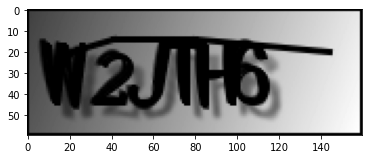

In [10]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('data/test/W2JTH6.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [11]:
#Lets Predict By Model
print("Predicted Captcha =",predict('data/test/W2JTH6.png', model))

Predicted Captcha = K8JRR6


In [12]:
# 전체 모델을 HDF5 파일로 저장합니다
# '.h5' 확장자는 이 모델이 HDF5로 저장되었다는 것을 나타냅니다
model.save('model/wetax_captcha_model.h5')

In [13]:
# 가중치와 옵티마이저를 포함하여 정확히 동일한 모델을 다시 생성합니다
new_model = load_model('model/wetax_captcha_model.h5')

# 모델 구조를 출력합니다
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 160, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 80, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
score = new_model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]], verbose=2)
print('='*100)
print('New Model Test Loss and accuracy:', score)

15/15 - 0s - loss: 83.5243 - dense_1_loss: 57.4055 - dense_3_loss: 3.8521 - dense_5_loss: 4.6992 - dense_7_loss: 6.1832 - dense_9_loss: 6.9457 - dense_11_loss: 4.4386 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.5778 - dense_5_accuracy: 0.5053 - dense_7_accuracy: 0.4286 - dense_9_accuracy: 0.3646 - dense_11_accuracy: 0.5672
New Model Test Loss and accuracy: [83.52427673339844, 57.4055061340332, 3.85206937789917, 4.699217796325684, 6.183202266693115, 6.945676326751709, 4.4386138916015625, 0.0, 0.5778251886367798, 0.505330502986908, 0.4285714328289032, 0.36460554599761963, 0.5671641826629639]


In [15]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/2KRU63.png', model))
print(predict('data/test/2YU6WY.png', model))
print(predict('data/test/ZZGXKX.png', model))
print(predict('data/test/VWPNTN.png', model))
print(predict('data/test/RQWJFQ.png', model))
print(predict('data/giro/3AM9EC.png', model))
print(predict('data/giro/AJ25BQ.png', model))
print(predict('data/giro/D3HJLD.png', model))
print(predict('data/giro/KDYBDY.png', model))
print(predict('data/giro/RKH6TX.png', model))

15/15 [==============================] - 0s 7ms/step - loss: 83.5243 - dense_1_loss: 57.4055 - dense_3_loss: 3.8521 - dense_5_loss: 4.6992 - dense_7_loss: 6.1832 - dense_9_loss: 6.9457 - dense_11_loss: 4.4386 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.5778 - dense_5_accuracy: 0.5053 - dense_7_accuracy: 0.4286 - dense_9_accuracy: 0.3646 - dense_11_accuracy: 0.5672
2XRU68
2YU6W7
2ZGVWX
6MRNFN
BQW6RQ
3AM9EC
AJ25BQ
D3HJLD
KDYBDY
KXT5FX
